In [1]:
import os

In [2]:
import json
from json import dumps
from kafka import KafkaProducer
import pandas as pd

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [4]:
from datetime import datetime
from time import sleep

In [5]:
#!pip install Faker
from faker import Faker
fake = Faker()

In [6]:
#import mysql connector library for mysql database
import mysql.connector

In [7]:
#create connection object for database 
conn_object=mysql.connector.connect(host="localhost",user="root",password="",port=3307)

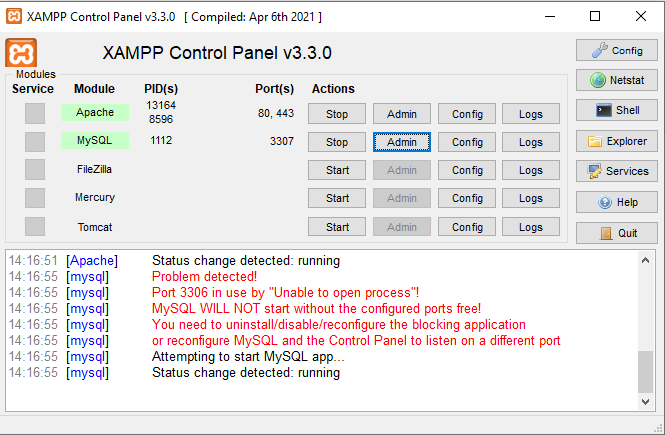

In [8]:
#create cursor for executing query
db_cursor = conn_object.cursor()

In [9]:
#create database
#db_cursor.execute("create database mysql_kafka_cassandra;")

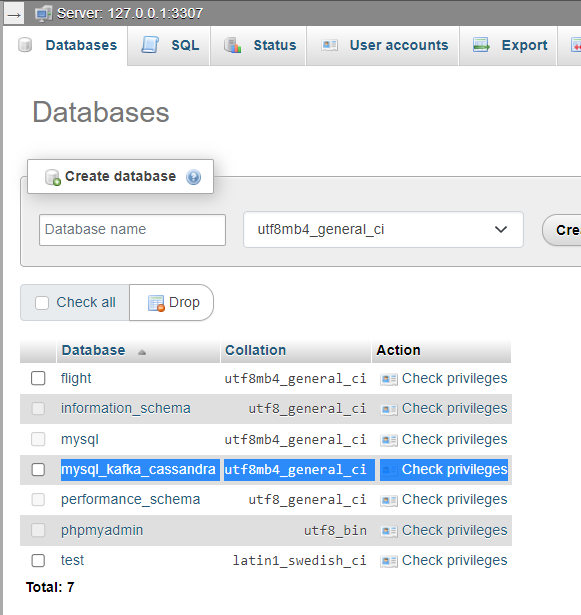

In [10]:
#create table
db_cursor.execute("use mysql_kafka_cassandra;")
db_cursor.execute("CREATE TABLE Persons \
    (personID int PRIMARY KEY, \
    lastName varchar(255), \
    firstName varchar(255), \
    address varchar(255), \
    city varchar(255), \
    created_at varchar(255));")

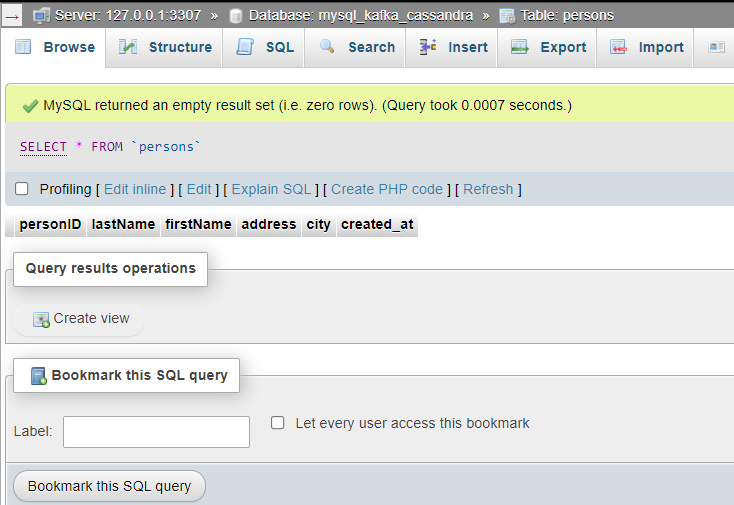

In [11]:
#truncate
db_cursor.execute("truncate table persons")
conn_object.commit()

In [12]:
#insert into table
for i in range (1, 11):
    
    #name
    name = fake.name()
    firstName, lastName = name.split(' ')[0], name.split(' ')[1]
    
    #address and city
    address = str(fake.address()).replace("\n",", ")
    city = address.split(",")[1].split(",")[0]
    
    #updated at 
    timeStamp = str(datetime.now()).split(".")[0]
    
    # excecute query
    db_cursor.execute("INSERT INTO Persons \
    (personID, lastName, firstName, address, city, created_at) \
    VALUES (%s, %s, %s, %s, %s, %s)" , (i, firstName, lastName, address, city, timeStamp))
    
    print('inserted -> ',firstName, lastName, address, city, timeStamp)
    
    sleep(1)

# finally commit all values at once to db
conn_object.commit()

inserted ->  Chloe James 878 Michael Rue, East Lawrence, MA 38120  East Lawrence 2023-05-20 23:18:04
inserted ->  Marcia Petty 343 Harris Meadows Suite 863, Chapmanside, SD 62855  Chapmanside 2023-05-20 23:18:05
inserted ->  Brianna Castro USS Hines, FPO AE 43534  FPO AE 43534 2023-05-20 23:18:06
inserted ->  Brandy Maldonado 0754 Joshua Rue, Lisaland, DE 36101  Lisaland 2023-05-20 23:18:07
inserted ->  Julie Brown 488 Andrews Mills, Hartshire, GA 73533  Hartshire 2023-05-20 23:18:08
inserted ->  Robert Miller 537 Gomez Locks Apt. 142, West Anthony, MS 82217  West Anthony 2023-05-20 23:18:09
inserted ->  Heather Welch 6595 Rodriguez Stravenue, Lake Robert, UT 32497  Lake Robert 2023-05-20 23:18:10
inserted ->  Michael Combs 94711 Gary Parks, Marystad, MA 30402  Marystad 2023-05-20 23:18:11
inserted ->  Mark Gill 236 Anderson Summit, Port Jacob, OH 35599  Port Jacob 2023-05-20 23:18:12
inserted ->  David Carson 575 Hodges Cape, Hernandezhaven, ME 94510  Hernandezhaven 2023-05-20 23:18:1


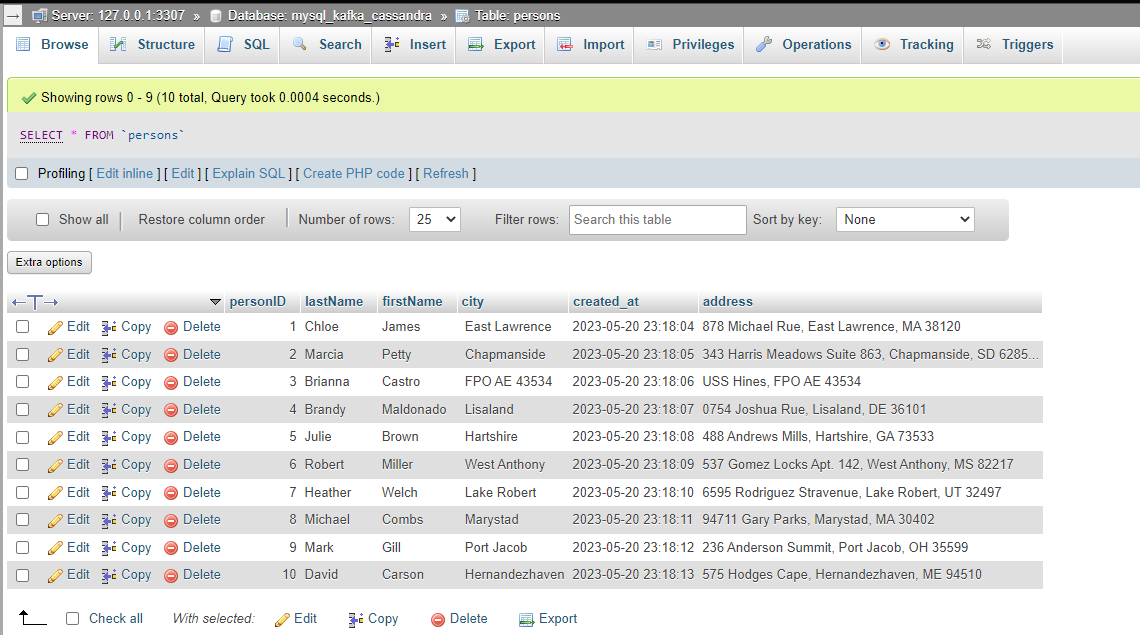

# Spark

# Read MYSQL Data

In [13]:
import findspark
findspark.init()

In [17]:
#import spark session
import pyspark
from pyspark.sql import SparkSession

# cassandra & kafka configs
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.datastax.spark:spark-cassandra-connector_2.12:3.1.0,org.apache.spark:spark-streaming-kafka-0-10_2.12:3.4.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.4.0 pyspark-shell --conf spark.cassandra.connection.host=127.0.0.1'

spark = SparkSession.builder.\
config("spark.jars", "mysql-connector-java-8.0.28.jar").\
master("local").appName("PySpark_MySQL").getOrCreate()

In [18]:
mysql_spark_read = spark.read.format("jdbc").option("url", "jdbc:mysql://localhost:3307/mysql_kafka_cassandra") \
    .option("driver", "com.mysql.jdbc.Driver").option("dbtable", "Persons") \
    .option("user", "root").option("password", "").load()

In [19]:
mysql_spark_read.show()

+--------+--------+---------+--------------------+---------------+-------------------+
|personID|lastName|firstName|             address|           city|         created_at|
+--------+--------+---------+--------------------+---------------+-------------------+
|       1|   Chloe|    James|878 Michael Rue, ...|  East Lawrence|2023-05-20 23:18:04|
|       2|  Marcia|    Petty|343 Harris Meadow...|    Chapmanside|2023-05-20 23:18:05|
|       3| Brianna|   Castro|USS Hines, FPO AE...|   FPO AE 43534|2023-05-20 23:18:06|
|       4|  Brandy|Maldonado|0754 Joshua Rue, ...|       Lisaland|2023-05-20 23:18:07|
|       5|   Julie|    Brown|488 Andrews Mills...|      Hartshire|2023-05-20 23:18:08|
|       6|  Robert|   Miller|537 Gomez Locks A...|   West Anthony|2023-05-20 23:18:09|
|       7| Heather|    Welch|6595 Rodriguez St...|    Lake Robert|2023-05-20 23:18:10|
|       8| Michael|    Combs|94711 Gary Parks,...|       Marystad|2023-05-20 23:18:11|
|       9|    Mark|     Gill|236 Anderson S

# Kafka

In [20]:
#Spark DataFrame to Pandas DataFrame
pdsDF = mysql_spark_read.toPandas()

In [21]:
pdsDF

,personID,lastName,firstName,address,city,created_at
0,1,Chloe,James,"878 Michael Rue, East Lawrence, MA 38120",East Lawrence,2023-05-20 23:18:04
1,2,Marcia,Petty,"343 Harris Meadows Suite 863, Chapmanside, SD ...",Chapmanside,2023-05-20 23:18:05
2,3,Brianna,Castro,"USS Hines, FPO AE 43534",FPO AE 43534,2023-05-20 23:18:06
3,4,Brandy,Maldonado,"0754 Joshua Rue, Lisaland, DE 36101",Lisaland,2023-05-20 23:18:07
4,5,Julie,Brown,"488 Andrews Mills, Hartshire, GA 73533",Hartshire,2023-05-20 23:18:08
5,6,Robert,Miller,"537 Gomez Locks Apt. 142, West Anthony, MS 82217",West Anthony,2023-05-20 23:18:09
6,7,Heather,Welch,"6595 Rodriguez Stravenue, Lake Robert, UT 32497",Lake Robert,2023-05-20 23:18:10
7,8,Michael,Combs,"94711 Gary Parks, Marystad, MA 30402",Marystad,2023-05-20 23:18:11
8,9,Mark,Gill,"236 Anderson Summit, Port Jacob, OH 35599",Port Jacob,2023-05-20 23:18:12
9,10,David,Carson,"575 Hodges Cape, Hernandezhaven, ME 94510",Hernandezhaven,2023-05-20 23:18:13


In [22]:
dict_data = pdsDF.to_dict('records')

In [23]:
dict_data[0]

{'personID': 1,
 'lastName': 'Chloe',
 'firstName': 'James',
 'address': '878 Michael Rue, East Lawrence, MA 38120',
 'city': ' East Lawrence',
 'created_at': '2023-05-20 23:18:04'}

# Kafka Producer

In [24]:
producer = KafkaProducer(bootstrap_servers=['localhost:9092'],
                         value_serializer=lambda x: 
                         dumps(x).encode('utf-8'))

In [25]:
for e in range(10):
    producer.send("myTopic", value=dict_data[e],key=json.dumps(dict_data[e]["personID"]).encode('utf-8'))

# Kafka Consumer

In [26]:
df = spark \
    .read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("subscribe", "myTopic") \
    .option("startingOffsets", "earliest") \
    .option("endingOffsets", "latest") \
    .load() \
    .select("value") \
    .selectExpr("CAST(value AS STRING) as json")

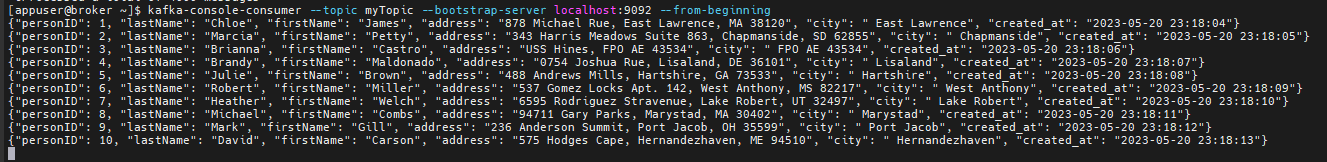

In [27]:
df.show()

+--------------------+
|                json|
+--------------------+
|{"personID": 1, "...|
|{"personID": 2, "...|
|{"personID": 3, "...|
|{"personID": 4, "...|
|{"personID": 5, "...|
|{"personID": 6, "...|
|{"personID": 7, "...|
|{"personID": 8, "...|
|{"personID": 9, "...|
|{"personID": 10, ...|
+--------------------+



In [28]:
jsonSchema = StructType([StructField("personID", StringType(), True), \
                         StructField("lastName", StringType(), True), \
                         StructField("firstName", StringType(), True), \
                         StructField("address", StringType(), True), \
                         StructField("city", StringType(), True), \
                         StructField("created_at", StringType(), True)])

In [29]:
# Parsing and selecting the right column data - Converting json read to table format
df = df.withColumn("jsonData", from_json(col("json"), jsonSchema)).select("jsonData.*")

In [31]:
df.show()

+--------+--------+---------+--------------------+---------------+-------------------+
|personID|lastName|firstName|             address|           city|         created_at|
+--------+--------+---------+--------------------+---------------+-------------------+
|       1|   Chloe|    James|878 Michael Rue, ...|  East Lawrence|2023-05-20 23:18:04|
|       2|  Marcia|    Petty|343 Harris Meadow...|    Chapmanside|2023-05-20 23:18:05|
|       3| Brianna|   Castro|USS Hines, FPO AE...|   FPO AE 43534|2023-05-20 23:18:06|
|       4|  Brandy|Maldonado|0754 Joshua Rue, ...|       Lisaland|2023-05-20 23:18:07|
|       5|   Julie|    Brown|488 Andrews Mills...|      Hartshire|2023-05-20 23:18:08|
|       6|  Robert|   Miller|537 Gomez Locks A...|   West Anthony|2023-05-20 23:18:09|
|       7| Heather|    Welch|6595 Rodriguez St...|    Lake Robert|2023-05-20 23:18:10|
|       8| Michael|    Combs|94711 Gary Parks,...|       Marystad|2023-05-20 23:18:11|
|       9|    Mark|     Gill|236 Anderson S

# Transformation 


In [32]:
import pyspark.sql.functions as F

In [34]:
type(df)

pyspark.sql.dataframe.DataFrame

In [35]:
# transformation to cassandra
df_filtered = df.withColumn("created_at", unix_timestamp("created_at", "yyyy-MM-dd HH:mm:ss")).filter(df['created_at'] >= F.lit('2023-05-20 23:18:08')).select('personID','firstName','city')

In [36]:
df_filtered.show()

+--------+---------+---------------+
|personID|firstName|           city|
+--------+---------+---------------+
|       5|    Brown|      Hartshire|
|       6|   Miller|   West Anthony|
|       7|    Welch|    Lake Robert|
|       8|    Combs|       Marystad|
|       9|     Gill|     Port Jacob|
|      10|   Carson| Hernandezhaven|
+--------+---------+---------------+



In [37]:
newDf=df_filtered.withColumnRenamed("personID","personid").withColumnRenamed("firstName","firstname")

In [38]:
newDf.show()

+--------+---------+---------------+
|personid|firstname|           city|
+--------+---------+---------------+
|       5|    Brown|      Hartshire|
|       6|   Miller|   West Anthony|
|       7|    Welch|    Lake Robert|
|       8|    Combs|       Marystad|
|       9|     Gill|     Port Jacob|
|      10|   Carson| Hernandezhaven|
+--------+---------+---------------+



# CASSANDRA - Write 
F:\Cassandra\apache-cassandra-3.9\bin>python2.exe cqlsh.py

In [39]:
# create new table manually for adding transformed data
# write transformed data
newDf.write.format("org.apache.spark.sql.cassandra").options(table="peopleinfo", keyspace="people").mode("append").save()

In [40]:
newDf.show()

+--------+---------+---------------+
|personid|firstname|           city|
+--------+---------+---------------+
|       5|    Brown|      Hartshire|
|       6|   Miller|   West Anthony|
|       7|    Welch|    Lake Robert|
|       8|    Combs|       Marystad|
|       9|     Gill|     Port Jacob|
|      10|   Carson| Hernandezhaven|
+--------+---------+---------------+



In [41]:
# read to validate
readCDF = spark.read.format("org.apache.spark.sql.cassandra").options(table="peopleinfo", keyspace="people").load()

In [42]:
readCDF.select("personid","firstname","city").orderBy("personid").show()

+--------+---------+---------------+
|personid|firstname|           city|
+--------+---------+---------------+
|       5|    Brown|      Hartshire|
|       6|   Miller|   West Anthony|
|       7|    Welch|    Lake Robert|
|       8|    Combs|       Marystad|
|       9|     Gill|     Port Jacob|
|      10|   Carson| Hernandezhaven|
+--------+---------+---------------+



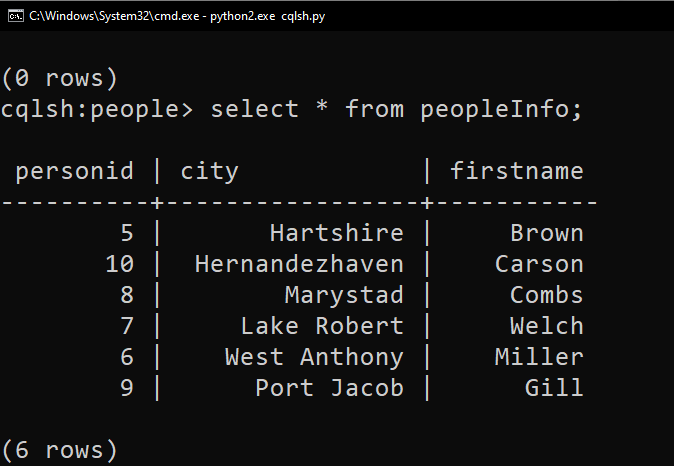